BIU Deep Learning Final Project

as learned from:
*   https://www.tensorflow.org/tutorials/generative/cyclegan
*   https://www.tensorflow.org/tutorials/generative/pix2pix

In [1]:
import tensorflow as tf
import numpy as np
import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

## hyperParameters

our final hyperparameters are:

In [2]:
# 
EPOCHS = 30
# 
LAMBDA = 10
#
DropOut = 0.65

### import the data from kaggle

In [3]:
!pip install -q kaggle

In [4]:
import gdown
url = "https://drive.google.com/u/1/uc?id=1zLZ02VuZu3njqsYf0-tWOJU-uOGVfiBz&export=download"
output = "kaggle.json"
gdown.download(url, output)

Downloading...
From: https://drive.google.com/u/1/uc?id=1zLZ02VuZu3njqsYf0-tWOJU-uOGVfiBz&export=download
To: /content/kaggle.json
100%|██████████| 68.0/68.0 [00:00<00:00, 44.8kB/s]


'kaggle.json'

In [5]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c gan-getting-started
! mkdir train
! unzip -qq gan-getting-started.zip -d train

100% 366M/367M [00:02<00:00, 133MB/s]
100% 367M/367M [00:02<00:00, 146MB/s]


In [6]:
photo_ds = tf.keras.utils.image_dataset_from_directory(
  "train/photo_jpg",
  labels=None,
  seed=123,
  image_size=(320,320),
  batch_size=1)

Found 7038 files belonging to 1 classes.


### import the selected 30 monet drawings from google drive

In [7]:
import gdown
url = "https://drive.google.com/drive/u/1/folders/1zbdIvBHk9Yrkf46vLe9PhoWK-amV2a8F"
gdown.download_folder(url, quiet=True)

['/content/monet-30/0a5075d42a.jpg',
 '/content/monet-30/4b0adf7c6f.jpg',
 '/content/monet-30/4c74254ad3.jpg',
 '/content/monet-30/4f4de0bbba.jpg',
 '/content/monet-30/6bbe0e63c6.jpg',
 '/content/monet-30/6d0e87f557.jpg',
 '/content/monet-30/11be65b3e9.jpg',
 '/content/monet-30/51bdd25f76.jpg',
 '/content/monet-30/89d970411d.jpg',
 '/content/monet-30/89fcbf2f76.jpg',
 '/content/monet-30/95a53d7b0b.jpg',
 '/content/monet-30/4260d1c556.jpg',
 '/content/monet-30/7017e6caa1.jpg',
 '/content/monet-30/910610e827.jpg',
 '/content/monet-30/4660310c3e.jpg',
 '/content/monet-30/a06b54dfe9.jpg',
 '/content/monet-30/b5c2fe7c4c.jpg',
 '/content/monet-30/b76d52e05a.jpg',
 '/content/monet-30/bf6db09354.jpg',
 '/content/monet-30/d9e8704878.jpg',
 '/content/monet-30/d729785cb8.jpg',
 '/content/monet-30/d4116437bb.jpg',
 '/content/monet-30/dcab49d080.jpg',
 '/content/monet-30/dcf5ea1040.jpg',
 '/content/monet-30/dd46691bd7.jpg',
 '/content/monet-30/e291f8144f.jpg',
 '/content/monet-30/eb3cc5c559.jpg',
 

In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  "monet-30",
  labels=None,
  seed=123,
  image_size=(320,320),
  batch_size=1)

Found 30 files belonging to 1 classes.


### preprocessing - normalization

scaling the data from [0,255] to (0,1) and resize it to 320*320.

In [9]:
def decode_image(image):
    #image = tf.image.decode_jpeg(image, channels=3)
    image_tensor = tf.cast(image, tf.float32)
    min_val = tf.reduce_min(image_tensor)
    max_val = tf.reduce_max(image_tensor)
    image_tensor = (image_tensor - min_val) / (max_val - min_val)
    image_tensor = tf.reshape(image_tensor, [1,320,320, 3])
    return image_tensor
photo_ds = photo_ds.map(decode_image)
train_ds= train_ds.map(decode_image)

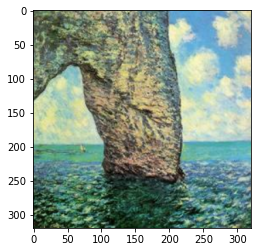

In [10]:
sample = next(iter(train_ds))
plt.imshow(sample[0])

### defining some usefull functions and classes for the CNN building

instace normalization layer:

In [11]:
class InstanceNormalization(tf.keras.layers.Layer):
  def __init__(self, epsilon=1e-5):
    super(InstanceNormalization, self).__init__()
    self.epsilon = epsilon

  def build(self, input_shape):
    self.scale = self.add_weight(
        name='scale',
        shape=input_shape[-1:],
        initializer=tf.random_normal_initializer(1., 0.02),
        trainable=True)

    self.offset = self.add_weight(
        name='offset',
        shape=input_shape[-1:],
        initializer='zeros',
        trainable=True)

  def call(self, x):
    mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
    inv = tf.math.rsqrt(variance + self.epsilon)
    normalized = (x - mean) * inv
    return self.scale * normalized + self.offset

downsample and upsample methods- defining conv2d and transposeconv2d by defined scheme.

In [12]:
def downsample(filters, size, norm_type='batchnorm', apply_norm=True, stride=2):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=stride, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_norm:
    if norm_type.lower() == 'batchnorm':
      result.add(tf.keras.layers.BatchNormalization())
    elif norm_type.lower() == 'instancenorm':
      result.add(InstanceNormalization())

  result.add(tf.keras.layers.LeakyReLU(0.1))

  return result

In [13]:
def upsample(filters, size, norm_type='batchnorm', apply_dropout=False, stride=2, crop = None):

  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2DTranspose(filters, size, strides=stride,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))
  if crop is not None:
    result.add(
        tf.keras.layers.Cropping2D(cropping=((1, 0), (1, 0)))
    )

  if norm_type.lower() == 'batchnorm':
    result.add(tf.keras.layers.BatchNormalization())
  elif norm_type.lower() == 'instancenorm':
    result.add(InstanceNormalization())

  if apply_dropout:
    result.add(tf.keras.layers.Dropout(DropOut))
#leaky relu
  result.add(tf.keras.layers.LeakyReLU(0.1))

  return result

### coding the generator - unet auto encoder

change the original unet architecture to get input and output of 320 * 320 * 3

In [14]:
def unet_generator(output_channels, norm_type='batchnorm'):
  down_stack = [
      downsample(64, 4, norm_type, apply_norm=False),  # (bs, 160, 160, 64)
      downsample(128, 4, norm_type),  # (bs, 80, 80, 128)
      downsample(256, 4, norm_type),  # (bs, 40, 40, 256)
      downsample(512, 4, norm_type),  # (bs, 20, 20, 512)
      downsample(512, 4, norm_type),  # (bs, 10, 10, 512)
      downsample(512, 4, norm_type),  # (bs, 5, 5, 512)
      downsample(512, 4, norm_type),  # (bs, 3, 3, 512)
      downsample(512, 4, norm_type, stride=3),  # (bs, 1, 1, 512)
  ]

  up_stack = [
      upsample(512, 4, norm_type, apply_dropout=True,stride = 3),  # (bs, 3, 3, 1024)
      upsample(512, 4, norm_type, apply_dropout=True, crop = True),  # (bs, 5, 5, 1024)
      upsample(512, 4, norm_type, apply_dropout=True),  # (bs, 10, 10, 1024)
      upsample(512, 4, norm_type),  # (bs, 20, 20, 1024)
      upsample(256, 4, norm_type),  # (bs, 40, 40, 512)
      upsample(128, 4, norm_type),  # (bs, 80, 80, 256)
      upsample(64, 4, norm_type),  # (bs, 160, 160, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 4, strides=2,
      padding='same', kernel_initializer=initializer,
      activation='tanh')  # (bs, 320, 320, 3)

  concat = tf.keras.layers.Concatenate()

  inputs = tf.keras.layers.Input(shape=[320, 320, 3])
  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    up.build(x.shape)
    x = up(x)
    x = concat([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

### coding the path gan discriminator

In [15]:
def discriminator(norm_type='batchnorm', target=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[None, None, 3], name='input_image')
  x = inp

  if target:
    tar = tf.keras.layers.Input(shape=[None, None, 3], name='target_image')
    x = tf.keras.layers.concatenate([inp, tar])  # (bs, 320, 3230, channels*2)

  down1 = downsample(64, 4, norm_type, False)(x)  # (bs, 160, 160, 64)
  down2 = downsample(128, 4, norm_type)(down1)  # (bs, 80, 80, 128)
  down3 = downsample(256, 4, norm_type)(down2)  # (bs, 40, 40, 256)
  down4 = downsample(256, 4, norm_type)(down3)  # (bs, 20, 20, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down4)  # (bs, 42, 42, 256)
  conv = tf.keras.layers.Conv2D(
      512, 4, strides=1, kernel_initializer=initializer,
      use_bias=False)(zero_pad1)  # (bs, 39, 39, 512)

  if norm_type.lower() == 'batchnorm':
    norm1 = tf.keras.layers.BatchNormalization()(conv)
  elif norm_type.lower() == 'instancenorm':
    norm1 = InstanceNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(norm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (bs, 41, 41, 512)

  last = tf.keras.layers.Conv2D(
      1, 4, strides=1,
      kernel_initializer=initializer)(zero_pad2)  # (bs, 38, 38, 1)

  if target:
    return tf.keras.Model(inputs=[inp, tar], outputs=last)
  else:
    return tf.keras.Model(inputs=inp, outputs=last)

check the respective field - for 39*39 and less the output will be in zero dimensions. so the for output of 1 * 1 * 1 * 1 we need input shape of 40 * 40

In [16]:
d1 = discriminator()
input_shape = (1, 40, 40, 3)
x = tf.random.normal(input_shape)
d1([x,x])

<tf.Tensor: shape=(1, 1, 1, 1), dtype=float32, numpy=array([[[[-0.00094079]]]], dtype=float32)>

after defining the generators and discriminators - let's declare them

In [17]:
OUTPUT_CHANNELS = 3

generator_g = unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f  = unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x  = discriminator(norm_type='instancenorm', target=False)
discriminator_y  = discriminator(norm_type='instancenorm', target=False)

we will use binary cross entropy for discrimnators loss

In [18]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### defininig loss functions

In [19]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [20]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated),generated)

In [21]:
def calc_cycle_loss(original_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(original_image - cycled_image))

  return LAMBDA * loss1

In [22]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

all the optimizers are set to adam with alpha = 0.0002 and beta = 0.5

In [23]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

show the result of image given a model.

In [24]:
def generate_images(model, test_input):
  prediction = model(test_input)

  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i])
    plt.axis('off')
  plt.show()

### the train step

In [25]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.

    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)

    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)

  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)

  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))

  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))
  return total_cycle_loss

In [26]:
sample_photo = next(iter(photo_ds))
sample_monet = next(iter(train_ds))

In [27]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

we will save the loss during the epochs here

In [28]:
  loss_list = []

during the training we could see how are the generators improved. then we catch the right epoch when the models are not be overfitted. we will see the monet generator and the second (reali live photos) generator too.

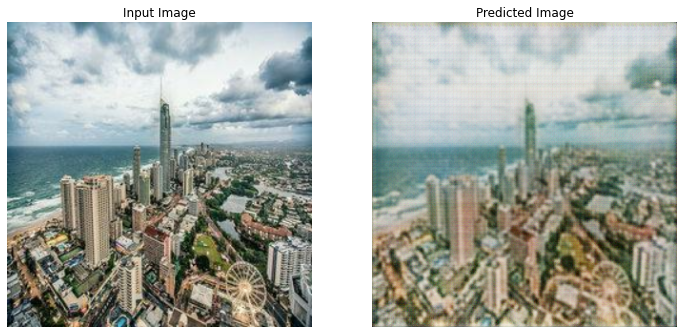

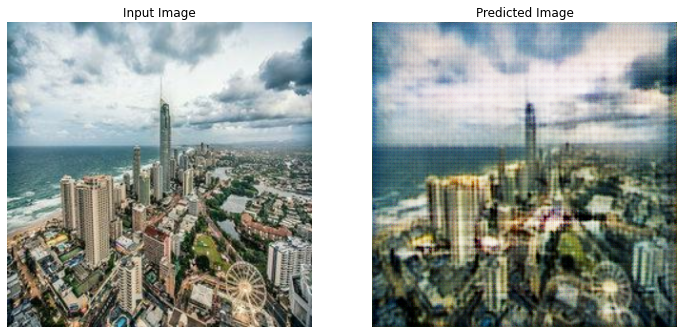

Saving checkpoint for epoch 30 at ./checkpoints/train/ckpt-6
Time taken for epoch 30 is 23.799520254135132 sec



In [29]:
for epoch in range(EPOCHS):
  start = time.time()
  step_loss = 0.0
  count = 0
  n = 0
  for photo_samp, monet_samp in tf.data.Dataset.zip((photo_ds, train_ds)):
    step_loss += train_step(photo_samp, monet_samp)
    count += 1
    if n % 10 == 0:
      print ('.', end='')
    n += 1
  loss_list.append(step_loss / count)
  clear_output(wait=True)

  generate_images(generator_g, sample_photo)
  generate_images(generator_f, sample_photo)

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

### results:
comapring photos by their original and their generative appreance.

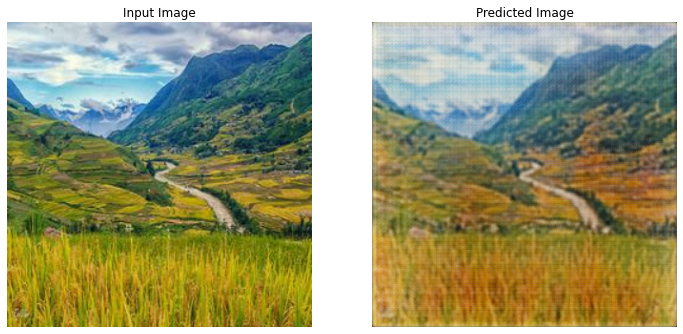

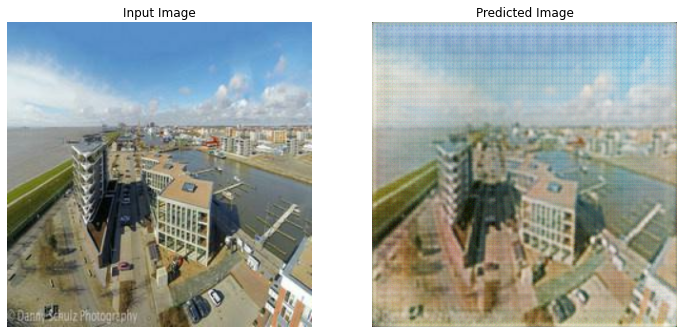

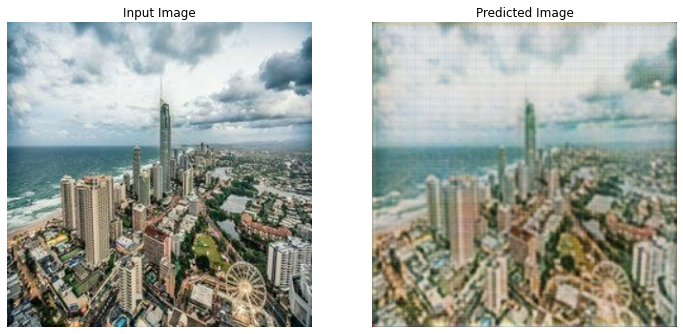

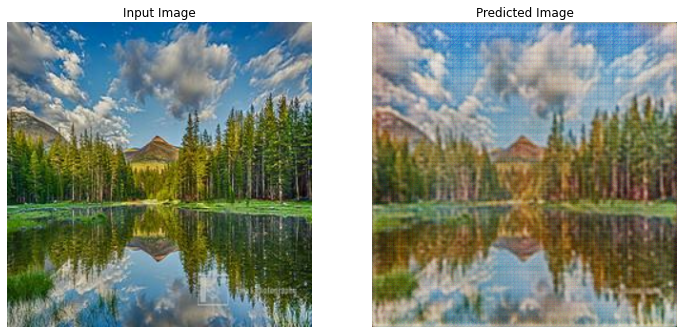

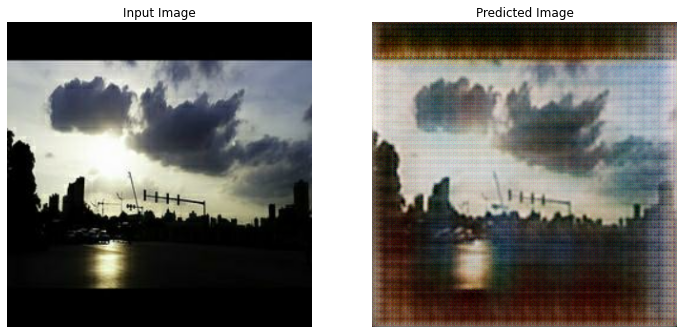

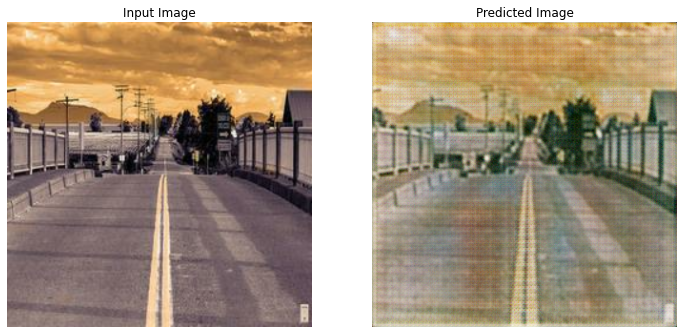

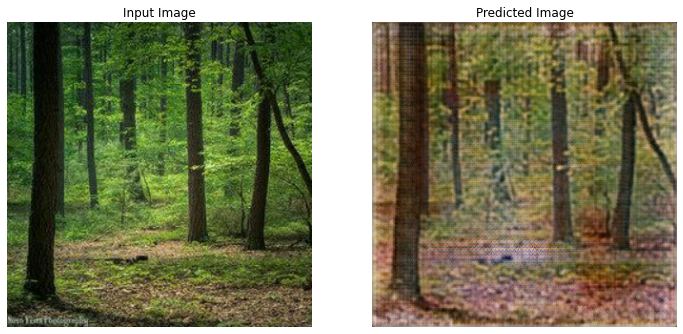

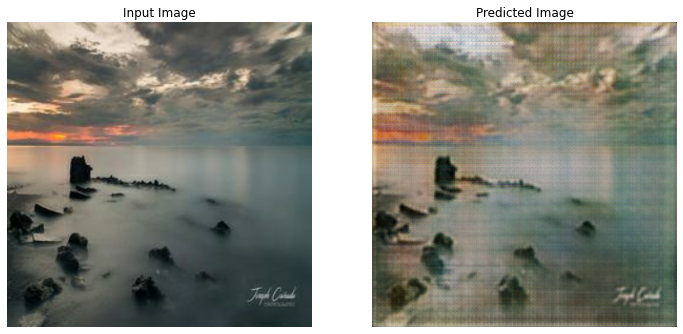

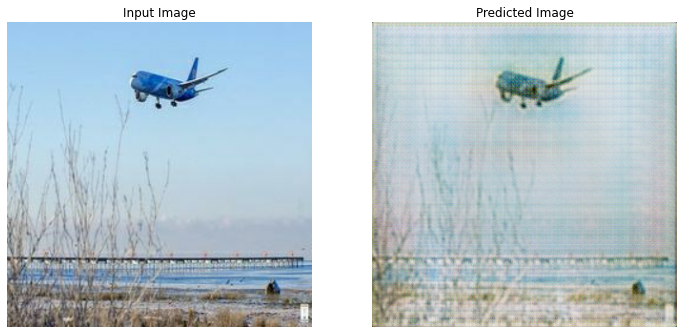

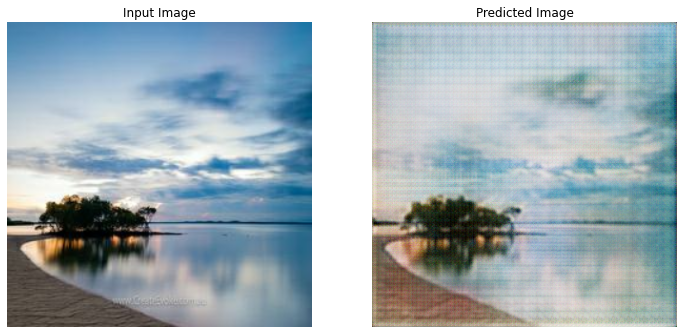

In [30]:
i =9
for image in photo_ds:
  generate_images(generator_g,image)
  i-=1
  if i<0:
    break

evaluating the performance of the training by loss (cycle loss) during epochs.

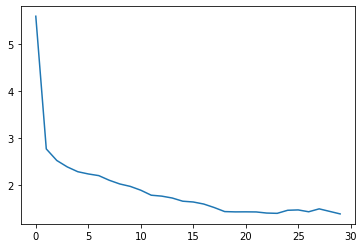

In [31]:
plt.plot(range(EPOCHS), loss_list)


saving our trained model.

In [35]:
generator_g.save("the_best_weights_ever2")

In [33]:
!zip -r the_best_weights_ever2.zip the_best_weights_ever2

  adding: the_best_weights_ever2/ (stored 0%)
  adding: the_best_weights_ever2/saved_model.pb (deflated 91%)
  adding: the_best_weights_ever2/variables/ (stored 0%)
  adding: the_best_weights_ever2/variables/variables.index (deflated 68%)
  adding: the_best_weights_ever2/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: the_best_weights_ever2/assets/ (stored 0%)
  adding: the_best_weights_ever2/fingerprint.pb (stored 0%)
  adding: the_best_weights_ever2/keras_metadata.pb (deflated 96%)


In [34]:
from google.colab import files
files.download("the_best_weights_ever2.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>